In [2]:
import inferno
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [3]:
from sine_data import train_dataset, valid_dataset

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import insp

In [5]:
import visdom
vis = visdom.Visdom()

In [6]:



X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [28]:
class InhCWRNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_modules = num_modules
        
        self.input_mod = nn.Linear(input_dim, output_dim)
        self.hidden_mod = nn.Linear(output_dim, output_dim, bias=False)
        
        #self.module_periods = nn.Parameter(torch.zeros(output_dim) + 1)
        #self.module_shifts = nn.Parameter(torch.zeros(output_dim))
        self.module_periods = nn.Parameter(torch.zeros(num_modules) + 1)
        self.module_shifts = nn.Parameter(torch.zeros(num_modules))
        
        self.f_mod = nn.Tanh()        
        
    def step(self, ti, xi, h):
        module_size = self.output_dim // self.num_modules
        
        acts = self.f_mod(self.input_mod(xi) + self.hidden_mod(h))
        module_acts = acts.view(-1, self.num_modules, module_size)
                
        # y=(sin(x)+1)/2 so we y is in [0;1]
        #gate = (torch.sin(ti * self.module_periods + self.module_shifts) + 1) / 2
        gate = (1/1 * (torch.sin((ti + self.module_shifts) * self.module_periods * 1)) +
                1/3 * (torch.sin((ti + self.module_shifts) * self.module_periods * 3)) +
                1/5 * (torch.sin((ti + self.module_shifts) * self.module_periods * 5)) + 
               1/7 * (torch.sin((ti + self.module_shifts) * self.module_periods * 7)) + 
               1/9 * (torch.sin((ti + self.module_shifts) * self.module_periods * 9)) + 
               1/11 * (torch.sin((ti + self.module_shifts) * self.module_periods * 11)) +
               1/13 * (torch.sin((ti + self.module_shifts) * self.module_periods * 13)) +
               1/15 * (torch.sin((ti + self.module_shifts) * self.module_periods * 15)))
        gate = (gate + 1) / 2
        gate = gate.view(1, -1, 1).expand_as(module_acts).contiguous()
        gate = gate.view(-1, self.output_dim)
                
        y = (1 - gate) * acts + gate * h
        
        return y, y
        
    def init_hidden(self):
        return Variable(torch.zeros(self.output_dim))
        
    def forward(self, x):
        t = x.size(1)
        ys = []
        h = self.init_hidden()
        for ti in range(t):
            xi = x[:, ti]
            yi, h = self.step(ti, xi, h)            
            ys.append(yi)
        return torch.stack(ys, dim=1), h

In [29]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [30]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, num_modules=8):
        super().__init__()
        
        self.rnn = InhCWRNN(1, num_hidden, num_modules)
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0 = self.rnn(x)
        
        vis.heatmap(l0[0].data.numpy(), win="act")
        vis.heatmap(self.rnn.module_periods.data.numpy().reshape(1, -1), win="periods")
        vis.heatmap(self.rnn.module_shifts.data.numpy().reshape(1, -1), win="shifts")

        l1 = self.clf(time_flatten(l0))
        return time_unflatten(l1, x.size())

In [31]:
class Trainer(inferno.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

### exp inhibition

In [35]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_relu = Trainer(module=ReconModel,
             optim=torch.optim.Adam,
             lr=0.005,
             max_epochs=60,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
            )

In [36]:
%pdb on
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.8104        0.8199  0.8821
      2        0.8155        0.4004  0.9020
      3        0.3820        0.2655  0.8216
      4        0.2531        0.1965  0.9417
      5        0.2013        0.1212  0.8444
      6        0.1411        0.0801  0.9287
      7        0.1051        0.0972  0.9125
      8        0.1185        0.1248  0.8652
      9        0.1404        0.1143  0.9520
     10        0.1281        0.0721  0.8490
     11        0.0860        0.0318  0.9432
     12        0.0459        0.0167  0.8857
     13        0.0294        0.0256  0.8401
     14        0.0360        0.0415  0.9388
     15        0.0493        0.0494  0.8925
     16        0.0549        0.0462  0.9446
     17        0.0503        0.0384  0.9307
     18        0.0417        0.0331  0.8829
     19        0.0365        0.0329  0.9067
     20        0.0365        0.0345

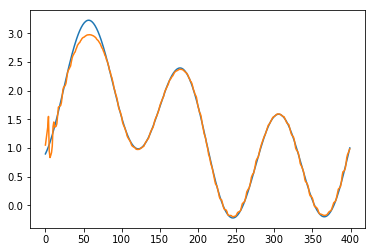

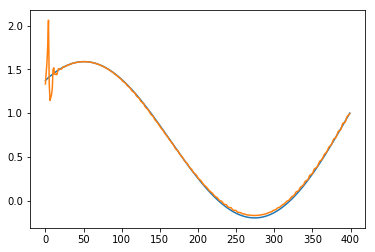

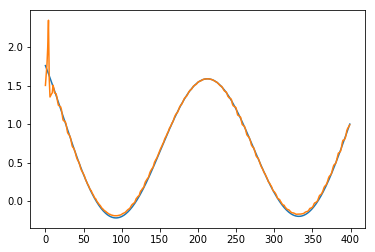

In [37]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])

In [65]:
%pdb on
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.8103        0.8194  0.5703
      2        0.8136        0.4002  0.7146
      3        0.3800        0.2663  0.6873
      4        0.2522        0.1979  0.5721
      5        0.2013        0.1224  0.6505
      6        0.1416        0.0812  0.5292
      7        0.1061        0.0981  0.6270
      8        0.1196        0.1260  0.5165
      9        0.1426        0.1162  0.6914
     10        0.1307        0.0742  0.6817
     11        0.0887        0.0338  0.6310
     12        0.0486        0.0186  0.6148
     13        0.0324        0.0274  0.5606
     14        0.0391        0.0434  0.6413
     15        0.0524        0.0514  0.5626
     16        0.0582        0.0483  0.6120
     17        0.0537        0.0404  0.5492
     18        0.0452        0.0351  0.5615
     19        0.0399        0.0347  0.5667
     20        0.0398        0.0362

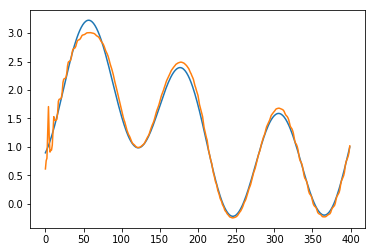

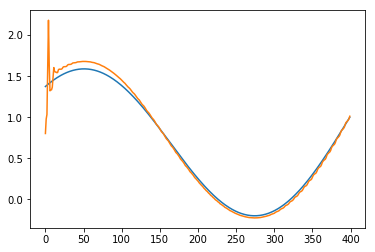

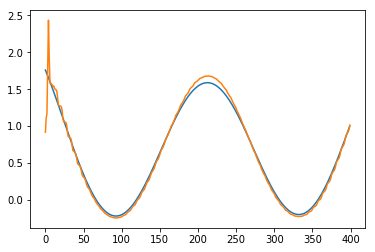

In [66]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])